In [1]:
# import library
from pathlib import Path
import math
import time
from collections import Counter
from tqdm import tqdm
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torch import Tensor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import Tensor
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import umap
import seaborn as sns
import pandas as pd
import japanize_matplotlib

In [2]:
version = '05-1'
model_dir = './model/' + version
data_path = f'data/eq05-1.txt'
test_data_path = f'data/eq05-1-test.txt'



## 初期設定

### データセット定義

In [3]:

# 事前設定
%load_ext autoreload
%autoreload 2
torch.set_printoptions(linewidth=100)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model_dir_path = Path(model_dir)

def read_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    src_data, tgt_data = [], []
    for line in lines:
        src, tgt = line.strip().split(' => ')
        src_data.append(src)
        tgt_data.append(tgt)
    return src_data, tgt_data
SPECIALS = ['<start>', '<end>', '<pad>', '<unk>']

def build_vocab(texts):
    vocab = {}
    idx = 0
    # 数字の語彙定義
    for i in range(10):
        vocab[str(i)] = idx
        idx += 1
    # その他の文字の語彙定義
    for text in texts:
        for char in text:
            if char not in vocab:
                vocab[char] = idx
                idx += 1
    # 特別語の語彙定義
    for sp in SPECIALS:
        vocab[sp] = idx
        idx += 1
    return vocab


def convert_text_to_indexes(text, vocab):
    # <start> と <end> トークンを追加して数値化
    return [vocab['<start>']] + [vocab[char] if char in vocab else vocab['<unk>'] for char in text] + [vocab['<end>']]

# データを処理して Train と Valid に分ける関数
# データを処理して Train と Valid に分ける関数
def data_process_split(src_texts, tgt_texts, vocab_src, vocab_tgt, valid_size=0.2):
    # データを数値化
    data = []
    for (src, tgt) in zip(src_texts, tgt_texts):
        src_tensor = torch.tensor(convert_text_to_indexes(src, vocab_src), dtype=torch.long)
        tgt_tensor = torch.tensor(convert_text_to_indexes(tgt, vocab_tgt), dtype=torch.long)
        data.append((src_tensor, tgt_tensor))
    
    # データのサイズを計算して、訓練データと検証データに分割
    data_size = len(data)
    valid_size = int(valid_size * data_size)
    train_size = data_size - valid_size

    # PyTorchのrandom_splitを使って分割
    train_data, valid_data = random_split(data, [train_size, valid_size])
    
    return train_data, valid_data



Using device: cuda:0


In [4]:
src_data, tgt_data = read_file(data_path)
vocab_src = vocab_tgt = build_vocab(src_data + tgt_data)
reverse_vocab = {idx: token for token, idx in vocab_tgt.items()}

PAD_IDX = vocab_src['<pad>']
START_IDX = vocab_src['<start>']
END_IDX = vocab_src['<end>']

### モデル定義

In [5]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [6]:
class TokenEmbedding(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=PAD_IDX)
        self.embedding_size = embedding_size
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.embedding_size)
    
    
class PositionalEncoding(nn.Module):
    
    def __init__(self, embedding_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('embedding_pos', embedding_pos)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.embedding_pos[: token_embedding.size(0), :])


class TransformerDecoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerDecoderLayerScratch, self).__init__()
        # Self-attention for the decoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Multihead attention for attending to encoder outputs (memory)
        self.cross_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Layer normalization layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        # Dropout
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)


    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        #Cross-attention
        tgt2, _ = self.cross_attn(tgt, memory, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)

        return tgt

class TransformerEncoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerEncoderLayerScratch, self).__init__()
        # Self-attention for the encoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # Self-attention
        memory, _ = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)
        memory = src + self.dropout1(memory)
        memory = self.norm1(memory)
        
        return memory


class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        embedding_size: int, vocab_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.token_embedding = TokenEmbedding(vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)
        self.encoder_layer = TransformerEncoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )

        self.decoder_layer = TransformerDecoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        
        # self.output = nn.Linear(embedding_size, vocab_size)

    def forward(
        self, src: Tensor, tgt: Tensor,
        mask_src: Tensor, mask_tgt: Tensor,
        padding_mask_src: Tensor, padding_mask_tgt: Tensor,
        memory_key_padding_mask: Tensor
    ):
        embedding_src = self.positional_encoding(self.token_embedding(src))
        memory = self.encoder_layer(embedding_src, mask_src, padding_mask_src)
        embedding_tgt = self.positional_encoding(self.token_embedding(tgt))
        outs = self.decoder_layer(
            embedding_tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.compute_output(outs)
    
    def compute_output(self, outs: Tensor):
        # token embeddingの重みを転置して出力層で使用する
        output = torch.matmul(outs/math.sqrt(self.token_embedding.embedding_size), self.token_embedding.embedding.weight.transpose(0, 1))
        return output

    def decode(self, tgt: Tensor, memory: Tensor, mask_tgt: Tensor):
        return self.decoder_layer(self.positional_encoding(self.token_embedding(tgt)), memory, mask_tgt)
    

def create_mask(src, tgt, PAD_IDX):
    
    seq_len_src = src.shape[0]
    seq_len_tgt = tgt.shape[0]

    mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)
    mask_tgt = generate_square_subsequent_mask(seq_len_tgt)

    padding_mask_src = (src == PAD_IDX).transpose(0, 1)
    padding_mask_tgt = (tgt == PAD_IDX).transpose(0, 1)
    
    return mask_src, mask_tgt, padding_mask_src, padding_mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones((seq_len, seq_len), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [7]:


#loaded_model用のSeq2Seqクラス
class Seq2SeqForSavedModel(Seq2SeqTransformer):
    def __init__(self, *args, **kwargs):
        super(Seq2SeqForSavedModel, self).__init__(*args, **kwargs)
        self.pca = None

    def positional_encoding(self, tensor: Tensor, maxlen=5000):
        embedding_size = tensor.size(-1)
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)
        return tensor + embedding_pos[: tensor.size(0), :].to(tensor.device)
    
    def self_attn_decoder(self, tgt, embedding_size):
        self_attn_wq, self_attn_wk, self_attn_wv = self.decoder_layer.self_attn.in_proj_weight.data.chunk(3, dim=0)
        self_attn_bq, self_attn_bk, self_attn_bv = self.decoder_layer.self_attn.in_proj_bias.data.chunk(3, dim=0)
        QW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
        KW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
        VW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
        self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
        AV = torch.matmul(self_attn_weights, VW)
        self_attn_output = torch.matmul(AV, self.decoder_layer.self_attn.out_proj.weight.data.T) + self.decoder_layer.self_attn.out_proj.bias.data
        return tgt + self_attn_output.permute(1, 0, 2), self_attn_output.permute(1, 0, 2), self_attn_weights

    def self_attn_encoder(self, tgt, embedding_size):
        self_attn_wq, self_attn_wk, self_attn_wv = self.encoder_layer.self_attn.in_proj_weight.data.chunk(3, dim=0)
        self_attn_bq, self_attn_bk, self_attn_bv = self.encoder_layer.self_attn.in_proj_bias.data.chunk(3, dim=0)
        QW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
        KW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
        VW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
        self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
        AV = torch.matmul(self_attn_weights, VW)
        self_attn_output = torch.matmul(AV, self.encoder_layer.self_attn.out_proj.weight.data.T) + self.encoder_layer.self_attn.out_proj.bias.data
        return tgt + self_attn_output.permute(1, 0, 2), self_attn_output.permute(1, 0, 2), self_attn_weights
    
    def cross_attn(self, tgt, memory, embedding_size):
        multi_attn_wq, multi_attn_wk, multi_attn_wv = self.decoder_layer.cross_attn.in_proj_weight.data.chunk(3, dim=0)
        multi_attn_bq, multi_attn_bk, multi_attn_bv = self.decoder_layer.cross_attn.in_proj_bias.data.chunk(3, dim=0)
        QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
        KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
        VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
        multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
        AV = torch.matmul(multi_attn_weights, VW)
        multi_attn_output = torch.matmul(AV, self.decoder_layer.cross_attn.out_proj.weight.data.T) + self.decoder_layer.cross_attn.out_proj.bias.data
        return tgt + multi_attn_output.permute(1, 0, 2), multi_attn_output.permute(1, 0, 2), multi_attn_weights

    def predict_next_token(self, src, tgt, embedding_size, device=device):
        memory = self.positional_encoding(self.token_embedding(src))
        tgt_embed = self.positional_encoding(self.token_embedding(tgt))
        tgt_mask = generate_square_subsequent_mask(tgt.size(0)).to(device).type(torch.bool)

        memory, _, _ = self.self_attn_encoder(memory, embedding_size)
        memory = self.encoder_layer.norm1(memory)
        # memory = self.encoder_layer.norm2(F.relu(self.encoder_layer.linear1(memory)) + memory)

        tgt, _, self_attn_weights = self.self_attn_decoder(tgt_embed, embedding_size)
        tgt = self.decoder_layer.norm1(tgt)
        tgt, _, multi_attn_weights = self.cross_attn(tgt, memory, embedding_size)
        tgt = self.decoder_layer.norm2(tgt)
        # tgt = self.decoder_layer.norm3(F.relu(self.decoder_layer.linear1(tgt)) + tgt)
        output = self.compute_output(tgt.transpose(0, 1)[:, -1])

        _, next_word = torch.max(output, dim=1)
        next_word = next_word.item()

        return next_word, self_attn_weights, multi_attn_weights
    


In [8]:
vocab_size_src = len(vocab_src)
vocab_size_tgt = len(vocab_tgt)
embedding_size = 4
nhead = 1
dim_feedforward = 4
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')

loaded_model = Seq2SeqForSavedModel(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()


Seq2SeqForSavedModel(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(16, 4, padding_idx=14)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (cross_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)



## Attentionの図示

Attentionがうまく言っている例

In [9]:

def plot_heatmap(attention_map, src_label=[], ys_label=[], title="Attention Map", fontsize=12):
    # ヒートマップとしてAttentionを描画
    plt.figure(figsize=(7, 6))
    sns.heatmap(attention_map, annot=False, cmap='viridis', cbar=True)
    plt.title(title)
    xticks = [f"{src_label[i]}" for i in range(len(src_label))]
    yticks = [f"{ys_label[i]}" for i in range(len(ys_label))]
    plt.xticks(ticks=np.arange(len(src_label))+0.5, labels=xticks, rotation=0, fontsize=fontsize)
    plt.yticks(ticks=np.arange(len(ys_label))+0.5, labels=yticks, rotation=0, fontsize=fontsize)
    plt.xlabel("Source", fontsize=fontsize)
    plt.ylabel("Target", fontsize=fontsize)
    plt.show()

In [10]:
import random

# 偶数と奇数のデータをランダムに生成
def generate_random_even_odd_data(num_samples=100):
    even_data = []
    odd_data = []
    for _ in range(num_samples):
        even_number = ''.join(str(random.randint(0, 9)) for _ in range(4)) + str(random.choice([0, 2, 4, 6, 8]))
        odd_number = ''.join(str(random.randint(0, 9)) for _ in range(4)) + str(random.choice([1, 3, 5, 7, 9]))
        even_data.append(even_number)
        odd_data.append(odd_number)
    return even_data, odd_data
# ランダムな偶数と奇数データを生成
even_data, odd_data = generate_random_even_odd_data()

even_src = [torch.LongTensor(convert_text_to_indexes(text, vocab=vocab_src)).to(device) for text in even_data]
odd_src = [torch.LongTensor(convert_text_to_indexes(text, vocab=vocab_src)).to(device) for text in odd_data]

# 確認
print("Examples of random data ending with Even:", even_data[:5])
print("Examples of random data ending with Odd:", odd_data[:5])
# 1個目の出力までを取得
text = even_data[0]

# 翻訳処理を実行
# seq_len_tgt = max([len(x[1]) for x in train_data])
tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

for _ in range(0):
    next_token, _, _ = loaded_model.predict_next_token(src, ys)
    ys = torch.cat([ys, torch.tensor([[next_token]], device=device)], dim=0)
print(ys)


Examples of random data ending with Even: ['08342', '74152', '53780', '32782', '19638']
Examples of random data ending with Odd: ['89723', '90539', '31133', '51729', '23213']
tensor([[12]], device='cuda:0')


(7, 7)


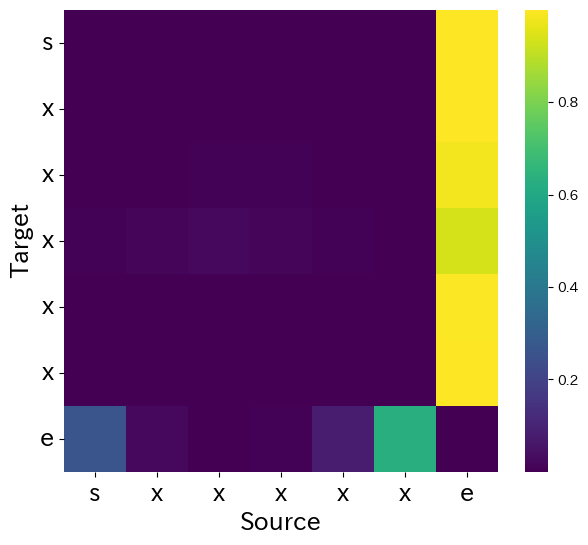

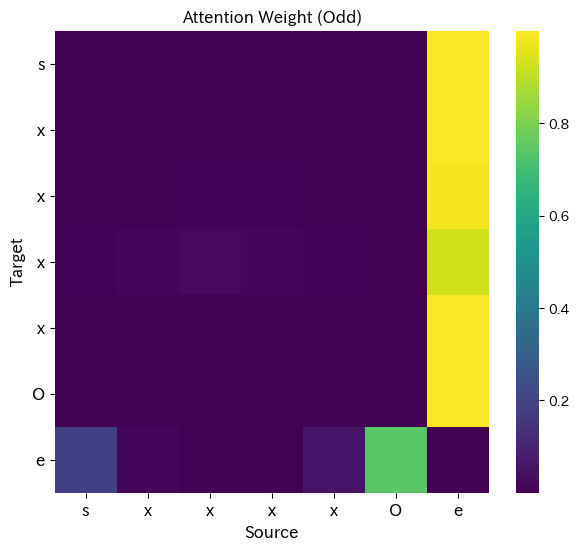

In [11]:
def extract_self_attention_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    attn_maps = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        memory = model.positional_encoding(model.token_embedding(src))
        _, _, attn_map = model.self_attn_encoder(memory, embedding_size)
        attn_maps.append(attn_map.detach().cpu().numpy())
    attn_maps = np.array(attn_maps)
    return attn_maps

# self-attentionのベクトルを抽出
even_vectors_sa = extract_self_attention_vectors(even_src, loaded_model).mean(axis=0).squeeze()
odd_vectors_sa = extract_self_attention_vectors(odd_src, loaded_model).mean(axis=0).squeeze()

# Cross AttentionのAttentionWeightのヒートマップを表示
print(even_vectors_sa.shape)
plot_heatmap(even_vectors_sa, title="", src_label="sxxxxxe", ys_label="sxxxxxe", fontsize=18)
plot_heatmap(odd_vectors_sa, title="Attention Weight (Odd)", src_label="sxxxxOe", ys_label="sxxxxOe")

(7,) (7,)
(7,)


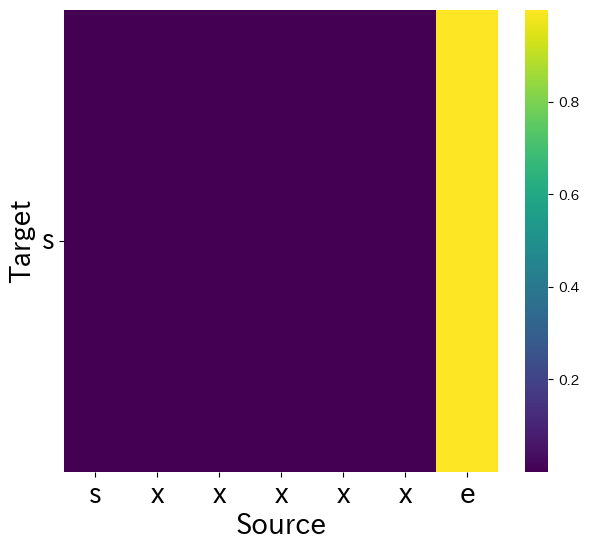

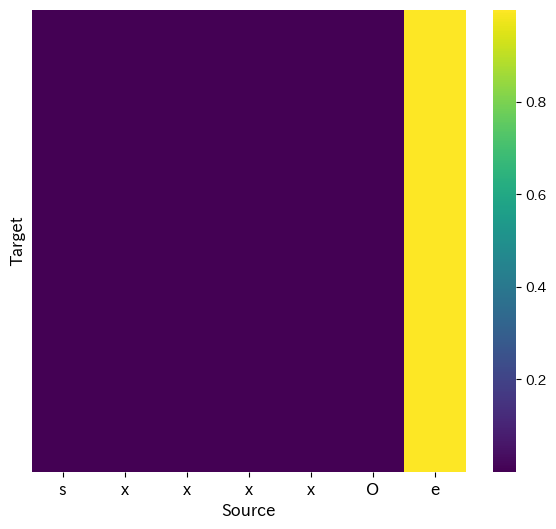

In [12]:

# Cross-AttentionのAttentionWeightの出力を取得
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = model.positional_encoding(model.token_embedding(ys))
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        tgt, tgt_, attention_weight = model.cross_attn(tgt, memory, embedding_size)
        vectors.append(attention_weight.detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array
    

# 偶数と奇数のCross Attention後のベクトルリストを取得
even_vectors_ca = extract_vectors(even_src, loaded_model).mean(axis=0).squeeze()
odd_vectors_ca = extract_vectors(odd_src, loaded_model).mean(axis=0).squeeze()
print(even_vectors_ca.shape, odd_vectors_ca.shape)# Cross AttentionのAttentionWeightのヒートマップを表示
print(even_vectors_ca.shape)
plot_heatmap([even_vectors_ca], title="", src_label="sxxxxxe", ys_label=["s"], fontsize=20)
plot_heatmap([odd_vectors_ca], title="", src_label="sxxxxOe")

In [13]:
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = model.positional_encoding(model.token_embedding(ys))
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        # Cross Attention
        multi_attn_wq, multi_attn_wk, multi_attn_wv = model.decoder_layer.cross_attn.in_proj_weight.data.chunk(3, dim=0)
        multi_attn_bq, multi_attn_bk, multi_attn_bv = model.decoder_layer.cross_attn.in_proj_bias.data.chunk(3, dim=0)
        VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
        VW = torch.matmul(VW, model.decoder_layer.cross_attn.out_proj.weight.data.T) + model.decoder_layer.cross_attn.out_proj.bias.data
        # VW = model.decoder_layer.norm2(VW)
        vectors.append(VW.detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array, tgt

# 偶数と奇数のCross Attention後のベクトルリストを取得
even_vectors_ca, sas = extract_vectors(even_src, loaded_model)
odd_vectors_ca, sas = extract_vectors(odd_src, loaded_model)
even_vectors_ca = even_vectors_ca.mean(axis=0)
odd_vectors_ca = odd_vectors_ca.mean(axis=0)
print(even_vectors_ca.shape, odd_vectors_ca.shape)
print(even_vectors_ca)
print(odd_vectors_ca)

(7, 4) (7, 4)
[[-0.3488557   0.4386819  -1.0742942  -1.401885  ]
 [-0.36292493  0.35176727 -0.8923496  -1.3242238 ]
 [-0.20712225  0.42911756 -0.9145925  -1.1210004 ]
 [-0.4011119   0.3010716  -0.854766   -1.3666302 ]
 [-0.5572283   0.16853732 -0.8419794  -1.608387  ]
 [-0.66349375 -0.00722635 -0.6682367  -1.6917083 ]
 [ 1.3164455  -0.6159627   0.6862799   1.2821819 ]]
[[-0.34885484  0.43868265 -1.0742947  -1.401884  ]
 [-0.35059333  0.36631975 -0.912077   -1.3174758 ]
 [-0.21624005  0.42049652 -0.90469474 -1.1284606 ]
 [-0.39436123  0.324975   -0.8945909  -1.3767263 ]
 [-0.561846    0.15875137 -0.8358043  -1.61428   ]
 [-0.57720065  0.17131594 -0.9001787  -1.6750617 ]
 [ 1.2974466  -0.7848996   0.86805445  1.3083366 ]]


In [14]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

for i in range(7):
    print(i)
    print(cos_sim(even_vectors_ca[i, :], odd_vectors_ca[i, :]))
    print(np.linalg.norm(even_vectors_ca[i, :]))
    print(np.linalg.norm(odd_vectors_ca[i, :]))

# print(np.linalg.norm(even_vectors_ca[5, :]))
# print(np.linalg.norm(odd_vectors_ca[5, :]))


0
1.0
1.8529792
1.8529786
1
0.99986404
1.6749064
1.6806941
2
0.9999334
1.523208
1.5216678
3
0.9997727
1.6881462
1.7195342
4
0.9999749
1.906501
1.9092778
5
0.9883512
1.9361542
1.9946586
6
0.99481285
2.0560663
2.182819


(4,)
[ 1.2970408 -0.7846292  0.8676267  1.3076918] [ 1.3157574  -0.61559546  0.68565834  1.2811179 ]
0.9948092


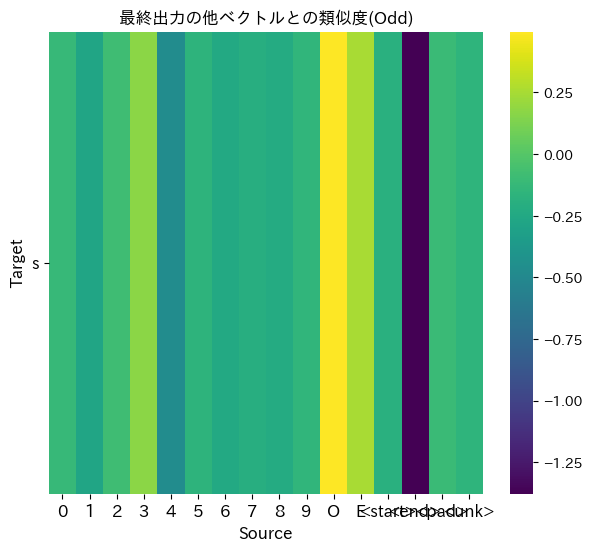

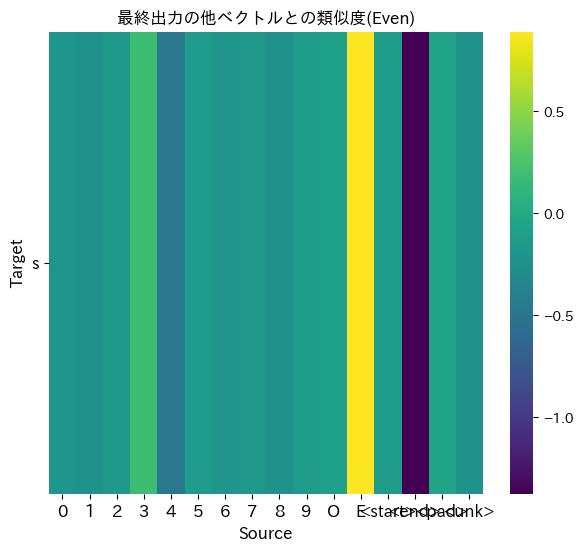

In [15]:
# 特にまとまっているOne-vectorについてVw*memを示す
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    VWxmems = []
    ca_vectors = []
    attn_maps = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = model.positional_encoding(model.token_embedding(ys))
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        ca_, ca, attn_map = model.cross_attn(tgt, memory, embedding_size)
        # ca = model.decoder_layer.norm2(ca)
        ca_vectors.append(ca.transpose(0, 1)[:, -1].detach().cpu().numpy().squeeze())
    tgt = tgt.detach().cpu().numpy().squeeze()
    ca_vectors = np.array(ca_vectors)
    return ca_vectors, tgt


# 偶数と奇数のCross Attention後のベクトルリストを取得
ca_vectors_odd, sas = extract_vectors(odd_src, loaded_model)
ca_vectors_even, sas = extract_vectors(even_src, loaded_model)

ca_vectors_odd, ca_vectors_even = ca_vectors_odd.mean(axis=0), ca_vectors_even.mean(axis=0)

# print(ca_vectors_odd)
# print(ca_vectors_odd + sas)

print(ca_vectors_odd.shape)
print(ca_vectors_odd, ca_vectors_even)
print(cos_sim(ca_vectors_even, ca_vectors_odd))

embedding_weight = loaded_model.token_embedding.embedding.weight.data.detach().cpu().numpy()
similarity_even_adjusted = np.matmul(embedding_weight, ca_vectors_odd+sas)
similarity_odd_adjusted = np.matmul(embedding_weight, ca_vectors_even+sas)

plot_heatmap([similarity_even_adjusted], title="最終出力の他ベクトルとの類似度(Odd)", src_label=reverse_vocab, ys_label="s")
plot_heatmap([similarity_odd_adjusted], title="最終出力の他ベクトルとの類似度(Even)", src_label=reverse_vocab, ys_label="s")


メモ：

以上はうまくいっていない例。つまり、Attentionが上手に効いていないが、学習は適切に分離できている。



